In [16]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd
import numpy as np
import os

from utils.basic_utils import config, read_dates, load_csvs, csv_load, excl, csv_store, numeric_cols
from utils.pricing import roll_vol, load_px_close, discret_rets, get_ind_index
from utils.fundamental import filter_cols, filter_cols
from scipy.stats import linregress

import matplotlib as mpl
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

In [17]:
# utility functions

conf_slope = lambda y: linregress(range(len(y)), y).slope

def top_recomm_by_class(pred_df, labels, top_items):
    mask = pred_df.hard_pred_label == pred_df.soft_pred_label
    agree_df = pred_df.loc[mask].drop_duplicates()
    # should add sector and industries, group for allocation insights
    # should add marketcap, beta, etc, group for risk exposure insights
    label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
    return agree_df.loc[label_mask]\
        .sort_values(by='soft_confidence', ascending=False)\
        .groupby(by='soft_pred_label').head(top_items)\
        .sort_values(by='soft_pred_class')

def pred_distrib(pred_df, count_col):
    dist = pd.value_counts(pred_df[count_col]).to_frame()
    dist['weights'] = dist / dist.sum()
    return dist

def add_desc_stats(df, descriptive_cols):
    
    tickers = df.index
    for k in descriptive_cols.keys():
        desc_df, cols = descriptive_cols[k]['df'], descriptive_cols[k]['columns']
        for c in cols: df.loc[:, c] = tickers.map(desc_df[c].to_dict()).values 

    df = clean_df(df, large_vals, div_cols)

    df.loc[:, 'pegRatio'] = df.forwardPE / (val_df.growthRate * 100)
    df.loc[:, 'size'] = discret_rets(df.marketCap, mkt_cap_cuts, mkt_cap_labels)
        
    return df

def clean_df(df, large_vals, div_cols):
    # convert large values to billions
    df.loc[:, large_vals] = df.loc[:, large_vals] / 10**9
    df.loc[:, div_cols] = df[div_cols].div(df.regularMarketPrice, axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

def ml_votes_by_class(fndm_dfs, group_mask):
    super_list = []
    for key in fndm_dfs.keys():
        df = fndm_dfs[key]
        super_list.append(
            fndm_dfs[key].loc[:, group_mask].set_index(re_index_col)\
            .rename(columns={group_mask[0]: key}))
    df = pd.concat(super_list, axis=1, sort=False)
    # df.apply(pd.value_counts).loc[fwd_ret_labels].style.background_gradient(cmap='RdYlGn')
    return df.T.apply(pd.value_counts).T

q_group = lambda x, q: x.quantile(q)

ticker_across_mls = lambda ticker, df: df.set_index('symbol').loc[ticker]

# equal weight ml_confidence
equal_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[:, x[1]].mean()

# take index and class, and calculate a dot product, weighted confidence
score_wgt_conf = lambda x: ticker_across_mls(x[0], lf_df).loc[
    :, [x[1], 'model']].set_index('model').T.mul(model_weights).sum(1).iloc[0]

def load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols, verbose=True):
    """ Read ML prediction files """
    print(f'Loading files for {tgt_date}')
    fndm_dfs = {k: pd.read_csv(csv_load(f'{s3_path[k]}{tgt_date}'), 
            index_col='pred_date', parse_dates=True) for k in key_list}

    super_list = []
    for key in fndm_dfs.keys(): 
        fndm_dfs[key].loc[:, 'model'] = key
        fndm_dfs[key] = fndm_dfs[key].loc[fndm_dfs[key].symbol.isin(eqty_symbols), :]
        df = fndm_dfs[key]
        if verbose: print(f'{key.upper()}, {df.symbol.shape[0]} unique symbols')
        super_list.append(df)
        
    return pd.concat(super_list, axis=0)

def get_wtd_ML_results(lf_df, model_weights):
    """ calculate model weighted class and confidence level for ranking / sorting """
    spc_df = lf_df.pivot_table(
        index=['symbol'], columns=['model'], 
        values=['pred_class'], aggfunc='mean')\
        ['pred_class'][list(model_weights.index)]
    wgt_class_df = (spc_df * model_weights.T).sum(axis=1)
    sc_df = lf_df.loc[:, ['symbol', 'confidence', 'model']]\
        .pivot(index='symbol', columns='model', values='confidence')\
                   .loc[:, model_weights.index]
    wgt_conf_df = (sc_df * model_weights.T).sum(axis=1)
    wtg_df = pd.concat([wgt_class_df, wgt_conf_df], axis=1, sort=False)
    wtg_df.columns = ['wtg_class', 'wtg_ML_prob']
    wtg_df[lf_df.index.name] = lf_df.index.unique()[0]
    
    return wtg_df

def visualize_MLs(lf_df, key_list):
    pvt_df = lf_df.pivot_table(
        index=['model'], columns=['soft_pred_label'], 
        values=['soft_confidence'], aggfunc='count')
    class_distrib = pvt_df.div(pvt_df.sum(axis=1), axis=0)['soft_confidence'][fwd_ret_labels]
    # plot mean class across models    
    class_distrib.mean(axis=0).plot.barh(title='Mean prediction by class',);
    plt.savefig('../images/ML_mean_weight.png', dpi=300, rot=0, bbox_inches='tight')
    # plot class distribution by model    
    class_distrib.plot(title='Prediction distribution by model', kind='barh', stacked=True, cmap='RdYlGn');
    plt.savefig('../images/ML_class_distrib.png', dpi=300, rot=0, bbox_inches='tight')
    return class_distrib.T[key_list]

def add_rank(df, show, lib_cols):
    lib_rank = df[lib_cols].rank(method='dense')
    # L_df[low_is_better]
    hib_rank = df[excl(show, lib_cols)].rank(numeric_only=True, ascending=False, method='dense')
    # L_df[excl(show, low_is_better)]
    df['rank'] = lib_rank.join(hib_rank).mean(1)
    return df[['rank'] + show].sort_values(by='rank')

In [18]:
# s3 paths
s3_path = {
    'macro': 'recommend/macro_ML/',
    'px_mom': 'recommend/micro_ML/',
    'bottom_up': 'recommend/bottomup_ML/',
    'fin_data': 'recommend/fdmn_ML-fin_data/',
    'key_statistics': 'recommend/fdmn_ML-key_statistics/',
    'eps_trend': 'recommend/fdmn_ML-eps_trend/',
    'eps_estimates': 'recommend/fdmn_ML-eps_estimates/',
    'day_quote': 'recommend/fdmn_ML-day_quote/',
    'iv_value': 'valuation/waterfall/'
}

In [25]:
# environment variables
bench = '^GSPC'
fwd_ret_labels = ['bear', 'short', 'negative', 'positive', 'long', 'bull']
show_classes = ['bear', 'short', 'long', 'bull']
min_confidence = 0.5
max_rows = 20

key = 'fin_data'
agg_funcs = ['count', 'median', 'max']
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

re_index_col = 'symbol'
value_col = 'soft_confidence'
show = ['symbol', 'soft_confidence']
mask_col, class_value = 'soft_pred_label', 'bull'
hard_vote, soft_vote = 'hard_pred_label', 'soft_pred_label'

large_vals = ['marketCap']
div_cols = ['targetMeanPrice', 'targetMedianPrice']

In [26]:
# context / descriptive data
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3

quotes = load_csvs('quote_consol', [tgt_date])

dollar_vol = ((quotes.averageDailyVolume10Day * quotes.regularMarketPrice) / 10**6)
quotes.loc[(dollar_vol > dollar_vol.quantile(0.2)) & (quotes['quoteType'] == 'EQUITY')] # the delta
mask = (dollar_vol > dollar_vol.quantile(0.1)) & (quotes['quoteType'] == 'EQUITY') & (quotes['regularMarketPrice'] > 5)
eqty_symbols = excl(quotes.loc[mask].symbol, ['GOOGL'])
# quotes.loc[quotes['quoteType'] == 'EQUITY'].index.difference(eqty_symbols) # the delta

profile = load_csvs('summary_detail', ['assetProfile'])
keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date)])
finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date)])

for df in (quotes, profile, keystats, finstats):
    df.set_index('symbol', drop=False, inplace=True)
    
path = 'valuation/waterfall/'
print(f'Loading file {path}{tgt_date}')
val_df = pd.read_csv(csv_load(path+tgt_date), parse_dates=True)
val_df.set_index('symbol', inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
val_df = val_df.loc[(np.abs(val_df.premDisc) < val_df.premDisc.median() * 3).values, :]

descriptive_cols = {
    'quotes': { 
        'df': quotes, 
        'columns': [
            'shortName', 'forwardPE', 'trailingPE', 
            'marketCap', 'regularMarketPrice', 
            'fiftyDayAverageChangePercent', 'fiftyTwoWeekHighChangePercent', 
            'fiftyTwoWeekLowChangePercent', 'twoHundredDayAverageChangePercent'
        ],},
    'profile': { 
        'df': profile, 
        'columns': ['sector', 'industry', 'country'],
    },
    'keystats': { 
        'df': keystats, 
        'columns': [
            'pegRatio', 'shortPercentOfFloat', 
            'beta', 'enterpriseToEbitda', 'enterpriseToRevenue'],
    },
    'finstats': { 
        'df': finstats, 
        'columns': [
            'earningsGrowth', 'recommendationMean', 
            'targetMeanPrice', 'targetMedianPrice', 
            'numberOfAnalystOpinions'],
    },
    'valuation': { 
        'df': val_df, 
        'columns': ['premDisc', 'growthRate'],
    },
}

Loading file quote/csv/2019-10-30
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-10-30
Loading file summary-categories/financialData/2019-10-30
Loading file valuation/waterfall/2019-10-30


In [21]:
# get latest pricing file from inferece server
px_close_ds = 'universe-px-vol-ds'
tmp_path = '../tmp/'
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.32.87.161:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

^C


### Macro / Risk Exposure

In [29]:
# Read macro predictions
key = 'macro'
show = ['^GSPC', 'pred_class', 'pred_label', 'confidence', 'bear', 'short', 'negative', 'positive', 'long', 'bull']
# show = ['hard_pred_label','soft_pred_label','soft_confidence','bear','short','neutral','long','bull']
macro_df = pd.read_csv(csv_load(f'{s3_path[key]}{tgt_date}'), index_col='pred_date', parse_dates=True)
macro_df.loc[:, show].round(3).tail()

,^GSPC,pred_class,pred_label,confidence,bear,short,negative,positive,long,bull
pred_date,,,,,,,,,,
2019-10-24,"3,010.29",2,negative,0.57,0.00,0.04,0.57,0.38,0.00,0.00
2019-10-25,"3,022.55",2,negative,0.63,0.00,0.20,0.63,0.17,0.00,0.00
2019-10-28,"3,039.42",2,negative,0.54,0.00,0.38,0.54,0.07,0.00,0.00
2019-10-29,"3,036.89",2,negative,0.45,0.01,0.27,0.45,0.28,0.00,0.00
2019-10-30,"3,032.52",0,bear,0.77,0.77,0.11,0.06,0.04,0.00,0.02


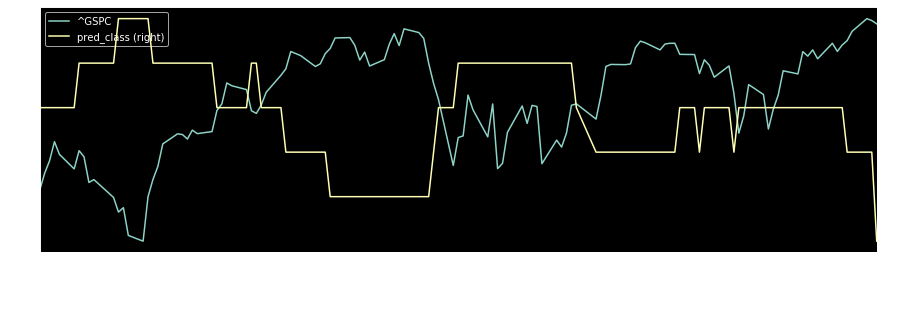

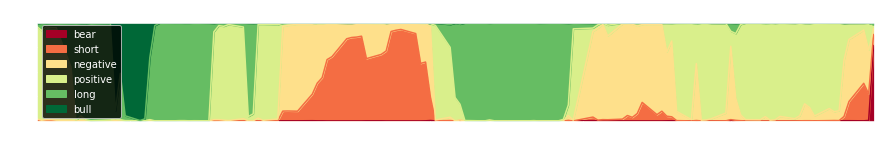

In [30]:
# Visualize macro predictions
pred_df = macro_df
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, 
    figsize=(15, 5));
os.makedirs('../images', exist_ok=True)
plt.savefig('../images/macro_chart.png', dpi=300, rot=0)
pred_df[fwd_ret_labels].plot.area(
        title='ML Model Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0);
f'Confidence Mean: {pred_df["confidence"].mean().round(3)}, \
    Median {pred_df["confidence"].median().round(3)}'
plt.savefig('../images/macro_prob.png', dpi=300)

### Bottom-up MLs

In [34]:
#
key_list = ['px_mom']
lf_df = load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols)

# Model score weights 
ml_score_dict = {
    'px_mom': 0.90, 'bottom_up': 0.87,
}
cut_off_confidence = 0.6
model_scores = np.array(list(map(ml_score_dict.get, list(key_list))))
adj_weights = (model_scores - cut_off_confidence) / (model_scores - cut_off_confidence).sum()
model_weights = pd.Series({x:y for x,y in zip(list(key_list), adj_weights)})
model_weights

Loading files for 2019-10-30
PX_MOM, 10660 unique symbols


px_mom   1.00
dtype: float64

### Recomendations

#### Weighted models

In [35]:
long_list = ['BABA', 'FB', 'AAPL', 'TSLA']

In [40]:
# weighted appraoch of two models
confidence_treshold = 0.7
filter_lf_df = lf_df.loc[(lf_df.confidence > confidence_treshold)]
wtg_df = get_wtd_ML_results(filter_lf_df, model_weights)
show = [
    'wtg_class', 'wtg_ML_prob', 'targetMedianPrice', 
    'premDisc', 'forwardPE', 'pegRatio', 'enterpriseToEbitda', 'enterpriseToRevenue', 'growthRate', 
    'fiftyDayAverageChangePercent', 'fiftyTwoWeekHighChangePercent',
    'fiftyTwoWeekLowChangePercent', 'twoHundredDayAverageChangePercent',
    'beta', 'enterpriseToEbitda', 'enterpriseToRevenue',
    'shortName', 'country', 'sector', 'industry', 'size',]

ValueError: Index contains duplicate entries, cannot reshape

In [39]:
wtg_df.loc[wtg_df.index.isin(long_list)].sort_values(by='wtg_class')

NameError: name 'wtg_df' is not defined

In [21]:
print(f'Long recommendations for {tgt_date}')

L_df = wtg_df.loc[(wtg_df['wtg_class'] > 3) & (wtg_df['wtg_ML_prob'] > confidence_treshold)]\
    .sort_values(by='wtg_ML_prob', ascending=False)

long_low_is_better = [
    'premDisc', 'forwardPE', 'pegRatio', 
    'fiftyDayAverageChangePercent', 'fiftyTwoWeekHighChangePercent',
    'fiftyTwoWeekLowChangePercent', 'twoHundredDayAverageChangePercent', 
    'beta', 'enterpriseToEbitda', 'enterpriseToRevenue',
]

L_df = add_desc_stats(L_df, descriptive_cols).sort_values(['wtg_class'], ascending=False)
L_df = add_rank(L_df, show, long_low_is_better)
L_df.T

Long recommendations for 2019-05-16


symbol,GDOT,TTM,RLGY,ING,CTL,ERJ,STMP,OAS,MYL,PTEN,...,SSYS,WAFD,CINF,0700.HK,HUBS,MLM,TREE,SAFM,RNG,TTD
rank,17.93,20.67,22.14,22.67,24.43,25.89,28.29,29.50,29.62,29.79,...,76.45,76.83,77.14,77.33,77.93,80.36,80.71,82.27,84.45,88.91
wtg_class,3.05,3.05,3.05,3.05,3.05,3.05,3.05,3.05,3.05,3.05,...,3.05,3.05,3.05,3.05,3.05,3.05,3.05,3.05,3.05,3.05
wtg_ML_prob,0.98,1.00,1.00,1.00,0.91,0.87,0.83,0.96,0.84,0.80,...,0.89,0.88,0.73,0.89,0.86,0.84,0.98,0.76,1.00,0.96
targetMedianPrice,1.37,1.27,1.36,1.69,1.17,1.40,1.15,1.60,1.56,1.38,...,0.98,1.01,0.92,1.03,1.01,1.08,1.07,0.99,1.08,1.04
premDisc,0.46,NaN,-0.73,NaN,-0.74,NaN,0.23,-0.40,-0.64,-1.18,...,NaN,0.93,0.48,NaN,1.92,NaN,2.09,NaN,NaN,NaN
forwardPE,12.51,2.72,6.75,11.41,8.19,15.31,13.02,13.40,4.45,-76.82,...,33.18,12.34,26.40,33.42,112.76,20.43,40.17,23.88,133.97,56.44
pegRatio,0.32,NaN,3.88,NaN,0.57,NaN,0.51,0.41,inf,-2.28,...,NaN,inf,4.89,NaN,1.06,NaN,1.29,NaN,NaN,NaN
enterpriseToEbitda,5.01,NaN,8.56,NaN,5.37,NaN,3.61,3.15,6.78,4.35,...,16.61,NaN,12.22,NaN,-217.59,15.86,48.64,32.36,"1,440.38",77.20
enterpriseToRevenue,0.81,NaN,0.89,NaN,2.12,NaN,1.21,2.00,2.13,1.06,...,1.32,9.03,2.48,NaN,12.88,4.20,6.24,1.03,13.27,17.09
growthRate,0.38,NaN,0.02,NaN,0.14,NaN,0.26,0.33,0.00,0.34,...,NaN,0.00,0.05,NaN,1.07,NaN,0.31,NaN,NaN,NaN


In [22]:
print(f'Short recommendations for {tgt_date}')

S_df = wtg_df.loc[(wtg_df['wtg_class'] < 1) & (wtg_df['wtg_ML_prob'] > confidence_treshold)]\
    .sort_values(by='wtg_ML_prob', ascending=False)

short_low_is_better = ['wtg_class', 'targetMedianPrice', ]

S_df = add_desc_stats(S_df, descriptive_cols).sort_values(['wtg_class'], ascending=False)
S_df = add_rank(S_df, show, short_low_is_better)
S_df.T

Short recommendations for 2019-05-16


symbol,VEEV,RGEN,MSI,EDU,VG,EA,DPZ,HAS,MAN,PANW,...,VLO,SNH,FTI,PVH,INTC,ENS,GRUB,DLPH,LYB,GIII
rank,4.45,5.00,10.43,10.91,11.73,13.00,13.00,13.36,13.79,13.86,...,20.50,20.50,21.43,22.43,23.36,23.50,23.64,24.31,24.79,24.86
wtg_class,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.47,...,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95,0.95
wtg_ML_prob,0.92,0.99,0.97,0.99,0.99,0.98,0.88,0.75,0.98,0.99,...,1.00,0.94,1.00,0.93,0.96,0.92,0.96,0.92,0.90,0.90
targetMedianPrice,0.90,1.02,1.05,1.23,1.26,1.13,1.12,1.11,1.07,1.27,...,1.23,0.98,1.26,1.32,1.16,1.59,1.59,1.30,1.22,1.46
premDisc,NaN,NaN,1.72,NaN,NaN,1.25,3.68,2.57,0.86,0.89,...,1.12,-0.73,-2.76,1.66,0.80,1.50,NaN,1.40,0.59,1.50
forwardPE,65.25,64.77,17.40,25.63,48.12,19.34,25.37,19.46,10.90,34.97,...,7.64,40.75,14.54,9.63,10.05,10.31,28.55,5.30,6.99,8.77
pegRatio,NaN,NaN,1.93,NaN,NaN,4.79,1.26,inf,2.72,1.78,...,1.88,inf,0.96,2.25,1.00,inf,NaN,7.69,inf,0.90
enterpriseToEbitda,83.53,65.09,14.97,29.26,27.54,19.49,24.02,14.83,7.08,230.87,...,6.84,10.35,7.42,8.53,6.80,10.38,42.52,5.35,6.71,7.25
enterpriseToRevenue,22.95,14.80,3.86,3.75,3.10,4.56,4.27,2.79,0.29,7.45,...,0.39,5.25,0.84,1.11,3.12,1.26,5.40,0.72,1.07,0.64
growthRate,NaN,NaN,0.09,NaN,NaN,0.04,0.20,0.00,0.04,0.20,...,0.04,0.00,0.15,0.04,0.10,0.00,NaN,0.01,0.00,0.10


#### Single model

In [23]:
# single model
active_model = key_list[0]
one_model = lf_df.loc[(lf_df.model == active_model)]
one_model = one_model.infer_objects()
print(f'Recommendatiosn for {active_model.upper()}')
one_model.loc[one_model.symbol.isin(long_list)].sort_values(by='pred_class')

Recommendatiosn for PX_MOM


,symbol,pred_class,pred_label,confidence,bear,short,neutral,long,bull,model
pred_date,,,,,,,,,,
2019-05-16,BABA,2,neutral,0.75,0.01,0.07,0.75,0.16,0.01,px_mom
2019-05-16,TSLA,2,neutral,0.87,0.00,0.12,0.87,0.00,0.01,px_mom
2019-05-16,AAPL,3,long,0.81,0.00,0.00,0.19,0.81,0.00,px_mom
2019-05-16,FB,3,long,0.47,0.01,0.00,0.37,0.47,0.15,px_mom


In [ ]:
print(f'Long recommendations for {tgt_date}')
mask = (one_model['pred_class'] > 2) & (one_model['confidence'] > confidence_treshold)
L_df = one_model.loc[mask].sort_values(by='confidence', ascending=False)
L_df

In [ ]:
print(f'Short recommendations for {tgt_date}')
mask = (one_model['pred_class'] < 2) & (one_model['confidence'] > confidence_treshold)
S_df = one_model.loc[mask].sort_values(by='confidence', ascending=False)
S_df

#### Daily recommendations

In [ ]:
lf_df = load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols)
wtg_df = get_wtd_ML_results(lf_df, model_weights)
wtg_df = add_desc_stats(wtg_df, descriptive_cols)

In [ ]:
# todays long positions
show = ['wtg_class','wtg_ML_prob','forwardPE', 'industry', 'targetMedianPrice', 'size']
L_df = wtg_df.loc[wtg_df['wtg_class'] > 3].sort_values(by='wtg_ML_prob', ascending=False).head(max_rows)
print(f'Long recommendations for {tgt_date}')
L_df.index

In [ ]:
# todays short positions
S_df = wtg_df.loc[wtg_df['wtg_class'] < 1].sort_values(by='wtg_ML_prob', ascending=False).head(max_rows)
print(f'Short recommendations for {tgt_date}')
S_df

#### Company details

In [31]:
ticker = 'TSLA'
show = [
    'pred_label','confidence',
    'bear', 'short', 'neutral', 'long', 'bull', 'model']
wgt_input = (ticker, 'confidence')
f'{quotes.loc[ticker].shortName}, {profile.loc[ticker].sector}, {profile.loc[ticker].industry}'

'Tesla, Inc., Consumer Cyclical, Auto Manufacturers'

In [32]:
# Company view across models
print(f'Model predictions for {ticker} on {tgt_date}')
print(f'Weighted ML confidence level: {score_wgt_conf(wgt_input)}')
lf_df.loc[lf_df['symbol'] == ticker, show]

Model predictions for TSLA on 2019-05-16
Weighted ML confidence level: 0.9295263133550944


,pred_label,confidence,bear,short,neutral,long,bull,model
pred_date,,,,,,,,
2019-05-16,neutral,0.87,0.00,0.12,0.87,0.00,0.01,px_mom
2019-05-16,neutral,1.00,0.00,0.00,1.00,0.00,0.00,bottom_up


In [ ]:
quotes.loc[ticker]

### Universe Intrinsic Value Analysis

In [34]:
# Value companies in the universe
iv_show = ['premDisc', 'forwardPE', 'targetMedianPrice', 'pegRatio', 'growthRate']
iv_sizes = ['mega', 'large', 'mid']

iv_mask = (val_df.premDisc < 0.95) & (val_df.premDisc > 0)
iv_mapper = val_df.loc[iv_mask, 'premDisc']
iv_df = add_desc_stats(iv_mapper.to_frame(), descriptive_cols)
iv_df = iv_df.loc[iv_df['size'].isin(iv_sizes) & (iv_df.targetMedianPrice > 1.1), :]

iv_df.groupby(by=['sector', ]).agg(['count', 'median'])\
    .sort_values(by=(iv_show[0], 'median'))[iv_show]

premDisc        forwardPE        targetMedianPrice  \
                          count median     count median             count   
sector                                                                      
Financial Services           62   0.36        62   9.59                62   
Basic Materials               7   0.55         7   7.86                 7   
Healthcare                    7   0.65         7  10.53                 7   
Industrials                  18   0.66        18  11.50                18   
Utilities                     2   0.67         2   3.58                 2   
Energy                       10   0.72         9   8.25                10   
Consumer Cyclical            22   0.73        22   9.51                22   
Technology                   18   0.74        18  14.04                18   
Consumer Defensive            4   0.77         4  10.51                 4   
Communication Services        2   0.83         1  15.74                 2   

                              pegRatio        growthRate         
                       median    count median      count median  
sector                                                           
Financial Services       1.15       62   0.70         62   0.15  
Basic Materials          1.28        7   0.46          7   0.17  
Healthcare               1.16        7   0.46          7   0.23  
Industrials              1.19       18   1.03         18   0.10  
Utilities              466.03        2    inf          2   0.06  
Energy                   1.31        9   0.25         10   0.34  
Consumer Cyclical        1.26       22   1.82         22   0.05  
Technology               1.22       18   1.03         18   0.16  
Consumer Defensive       1.12        4   1.56          4   0.17  
Communication Services   1.22        1    inf          2   0.00

In [35]:
show = [
    'targetMedianPrice', 
    'premDisc', 'forwardPE', 'pegRatio', 'enterpriseToEbitda', 'enterpriseToRevenue', 'growthRate', 
    'fiftyDayAverageChangePercent', 'fiftyTwoWeekHighChangePercent',
    'fiftyTwoWeekLowChangePercent', 'twoHundredDayAverageChangePercent',
    'beta', 'enterpriseToEbitda', 'enterpriseToRevenue',
    'shortName', 'country', 'sector', 'industry', 'size',]
summary = add_rank(iv_df, show, long_low_is_better)
# add_rank(iv_df, show, long_low_is_better).tail(10)

In [36]:
iv_df.loc[:, iv_show + ['sector', 'size']].sort_values(
    by=['size', 'premDisc', 'sector'], ascending=False).head(20)

,premDisc,forwardPE,targetMedianPrice,pegRatio,growthRate,sector,size
symbol,,,,,,,
AAPL,0.93,14.87,1.16,5.45,0.03,Technology,mega
GOOGL,0.90,22.10,1.14,1.36,0.16,Technology,mega
GOOG,0.90,21.94,1.15,1.35,0.16,Technology,mega
FB,0.69,20.06,1.20,0.60,0.34,Technology,mega
SWKS,0.95,9.94,1.32,2.13,0.05,Technology,large
CHL,0.94,nan,1.16,nan,0.00,Communication Services,large
REPYY,0.92,nan,2.30,nan,0.17,Energy,large
WBA,0.90,8.72,1.11,inf,0.00,Consumer Defensive,large
NTAP,0.89,13.91,1.15,2.85,0.05,Technology,large
